# Exploring the Rosetta Stone of Human Capital

This assignment is based on the working paper [A Rosetta Stone of Human Capital](https://www.cgdev.org/publication/rosetta-stone-human-capital), by Dev Patel and Justin Sandefur and all the analytics are run corresponding to the analytics of the paper. For better understanding, you can also read the related article at [The Economist](https://www.economist.com/graphic-detail/2020/10/03/its-better-to-be-a-poor-pupil-in-a-rich-country-than-the-reverse).

As you may know, there are different tests that measure reading and writing skills at school among countries in the world. The problem is that not all countries use the same tests. The basic contribution of the authors was to come up with a way to facilitate conversion between test scores in different countries. In this way they have created what they call a "Rosetta Stone of Human Capital", because it allows us to compare human capital across the different countries.

---

> Evangelia Papantoni, 8170091 <br />
> Department of Management Science and Technology <br />
> Athens University of Economics and Business <br />
> aliki.ntouzgou@gmail.com


<b><i>Please note that all the files used for the analysis below are saved in the same catalog, named Rosetta Data.</i></b>

Importing all the necessary libraries we are going to need.

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import seaborn as sns
import scipy.stats.stats as stats

pd.options.display.float_format = '{:,.2f}'.format

%matplotlib inline

---

## Income and Test Results

The income study will take place in two places. 

- Examine the correlation between income <-> TIMSS and income <-> PIRLS
- Examine the correlation of looged income <-> TIMSS and logged income <-> PIRLS 

### TIMSS & PIRLS

- *TIMSS*: measures the mathematical ability of a country.
- *PIRLS*: measures the reading ability of a country.

We shall read the dataset for TIMSS and PIRLS

In [92]:
countryData = pd.read_excel('https://www.cgdev.org/sites/default/files/patel-sandefur-human-capital-final-results.xlsx',
                               sheet_name='Country Scores')
countryData.head()

,Country,Country Code,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,U.A.E.,ARE,64.00,63.98,437.00,440.00
1,Argentina,ARG,51.00,66.00,406.65,431.44
2,Armenia,ARM,71.51,NaN,454.00,NaN
3,Australia,AUS,90.00,92.93,520.00,534.00
4,Austria,AUT,95.30,97.10,511.00,533.00


We read the `wdiData` that contains income data per country as given by the World Bank.

In [6]:
wdiData = pd.read_csv('WDI_csv/WDI_data.csv')
wdiData.head()

,Country Name,Country Code,Series Name,Series Code,2015 [YR2015]
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,1809.01648820483
1,Afghanistan,AFG,"School enrollment, primary (% net)",SE.PRM.NENR,..
2,Afghanistan,AFG,"School enrollment, primary (% gross)",SE.PRM.ENRR,107.225357055664
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,10971.2925173789
4,Albania,ALB,"School enrollment, primary (% net)",SE.PRM.NENR,95.1996002197266


We create the GDP per capita (PPP) dataset. We pick the needed columns. We rename the `2015 [YR2015]` to more understable form and we remove the empty ones. We transform it's type as float so we can handle it better.

In [22]:
gdpPerCapita = wdiData.loc[wdiData['Series Name'].isin(['GDP per capita, PPP (constant 2011 international $)'])].copy()
gdpPerCapita.rename(columns={"2015 [YR2015]": "GDP Per Capita"}, inplace=True)
gdpPerCapita = gdpPerCapita.loc[gdpPerCapita['GDP Per Capita'] != '..']
gdpPerCapita = gdpPerCapita.astype({"GDP Per Capita": float})
gdpPerCapita.head()

,Country Name,Country Code,Series Name,Series Code,GDP Per Capita
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"1,809.02"
3,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"10,971.29"
6,Algeria,DZA,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"13,724.72"
15,Angola,AGO,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"6,231.07"
18,Antigua and Barbuda,ATG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"20,154.95"


We merge based on `Country Code` the the country data and the GDP. We keep the needed columns and we rename them. We calculate the log GDP 

In [29]:
TIMSS_GDP = pd.merge(gdpPerCapita, countryData, on='Country Code', how='inner')
TIMSS_GDP = TIMSS_GDP[['Country Name', 'Country Code', 'Series Name', 'GDP Per Capita', 'Median Math Score (TIMSS Scale, 4th Grade)']]
TIMSS_GDP.rename(columns={"Median Math Score (TIMSS Scale, 4th Grade)": "TIMSS"}, inplace=True)
TIMSS_GDP.rename(columns={"GDP Per Capita": "Log GDP per Capita (PPP) in 2015"}, inplace=True)
TIMSS_GDP['Log GDP per Capita (PPP) in 2015'] = np.log(TIMSS_GDP['Log GDP per Capita (PPP) in 2015'])
TIMSS_GDP.head()

,Country Name,Country Code,Series Name,Log GDP per Capita (PPP) in 2015,TIMSS
0,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...",9.86,406.65
1,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...",9.01,454.00
2,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...",10.69,520.00
3,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...",10.70,511.00
4,Azerbaijan,AZE,"GDP per capita, PPP (constant 2011 internation...",9.72,465.00


In [31]:
TIMSS_GDP.isna().sum()

Country Name                        0
Country Code                        0
Series Name                         0
Log GDP per Capita (PPP) in 2015    0
TIMSS                               7
dtype: int64

We see sum NaN values here and we need to drop them

In [33]:
TIMSS_GDP.dropna(inplace=True)
TIMSS_GDP.reset_index(drop=True, inplace=True)
TIMSS_GDP.isna().sum()

Country Name                        0
Country Code                        0
Series Name                         0
Log GDP per Capita (PPP) in 2015    0
TIMSS                               0
dtype: int64

We create the same dataset as above with the PIRLS scores:

In [34]:
PIRLS_GDP = pd.merge(gdpPerCapita, countryData, on='Country Code', how='inner')
PIRLS_GDP = PIRLS_GDP[['Country Name', 'Country Code', 'Series Name', 'GDP Per Capita', 'Median Reading Score (PIRLS Scale, 4th Grade)']]
PIRLS_GDP.rename(columns={"Median Reading Score (PIRLS Scale, 4th Grade)": "PIRLS"}, inplace=True)
PIRLS_GDP.rename(columns={"GDP Per Capita": "Log GDP per Capita (PPP) in 2015"}, inplace=True)
PIRLS_GDP['Log GDP per Capita (PPP) in 2015'] = np.log(PIRLS_GDP['Log GDP per Capita (PPP) in 2015'])
PIRLS_GDP.head()

,Country Name,Country Code,Series Name,Log GDP per Capita (PPP) in 2015,PIRLS
0,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...",9.86,431.44
1,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...",9.01,NaN
2,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...",10.69,534.00
3,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...",10.70,533.00
4,Azerbaijan,AZE,"GDP per capita, PPP (constant 2011 internation...",9.72,467.00


In [20]:
PIRLS_GDP.isna().sum()

Country Name                         0
Country Code                         0
Series Name                          0
Log GDP per Capita (PPP) in 2015     0
PIRLS                               10
dtype: int64

Exclude the NaN values as before.

In [21]:
PIRLS_GDP.dropna(inplace=True)
PIRLS_GDP.reset_index(drop=True, inplace=True)
PIRLS_GDP.isna().sum()

,Country Name,Country Code,Series Name,Log GDP per Capita (PPP) in 2015,PIRLS
0,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...",9.86,431.44
1,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...",10.69,534.00
2,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...",10.70,533.00
3,Azerbaijan,AZE,"GDP per capita, PPP (constant 2011 internation...",9.72,467.00
4,Benin,BEN,"GDP per capita, PPP (constant 2011 internation...",7.59,394.20


Lets do a regrassion to investigate the relationship between logged income and TIMMS score:

In [35]:
TIMSS_GDP.rename(columns={"Log GDP per Capita (PPP) in 2015": "logGDP"}, inplace=True)
mod = smf.ols("TIMSS ~ logGDP", data=TIMSS_GDP)
timss_res = mod.fit()
timss_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  TIMSS   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.342
Method:                 Least Squares   F-statistic:                     37.42
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           5.07e-08
Time:                        00:10:38   Log-Likelihood:                -396.25
No. Observations:                  71   AIC:                             796.5
Df Residuals:                      69   BIC:                             801.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     46.1170     66.734      0.691      0.492     -87.013     179.247
logGDP        41.7460      6.824      6.117      0.000      28.132      55.360
==============================================================================
Omnibus:                        1.225   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.078
Skew:                          -0.298   Prob(JB):                        0.583
Kurtosis:                       2.898   Cond. No.                         85.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

> Just by looking the R-squared value (0.352) which is not high still shows a relationship. The plot below shows the above relationship.

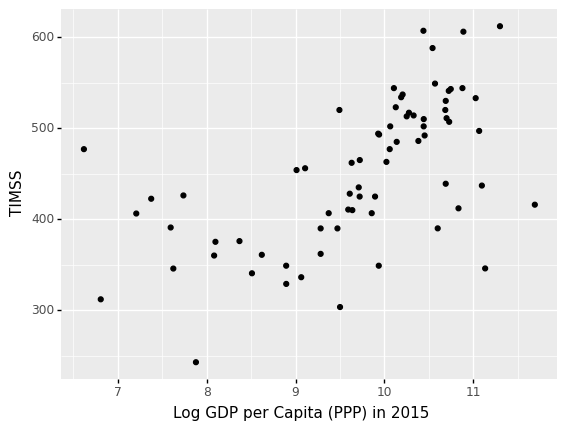

<ggplot: (313652812)>

In [36]:
TIMSS_GDP.rename(columns={"logGDP": "Log GDP per Capita (PPP) in 2015"}, inplace=True)
ggplot(data=TIMSS_GDP) + \
    geom_point(mapping=aes(x='Log GDP per Capita (PPP) in 2015', y='TIMSS'))

The same analysis applies for the PIRLS score

In [37]:
PIRLS_GDP.rename(columns={"Log GDP per Capita (PPP) in 2015": "logGDP"}, inplace=True)
mod = smf.ols("PIRLS ~ logGDP", data=PIRLS_GDP)
pirls_res = mod.fit()
pirls_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  PIRLS   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.449
Method:                 Least Squares   F-statistic:                     55.61
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           2.48e-10
Time:                        00:18:27   Log-Likelihood:                -367.97
No. Observations:                  68   AIC:                             739.9
Df Residuals:                      66   BIC:                             744.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     42.6191     57.790      0.737      0.463     -72.762     158.000
logGDP        43.9124      5.889      7.457      0.000      32.155      55.669
==============================================================================
Omnibus:                       10.020   Durbin-Watson:                   2.089
Prob(Omnibus):                  0.007   Jarque-Bera (JB):               10.389
Skew:                          -0.951   Prob(JB):                      0.00555
Kurtosis:                       3.226   Cond. No.                         85.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Same as before the the R-squared is not high enough to show the relatioship. The following plot, however, will.

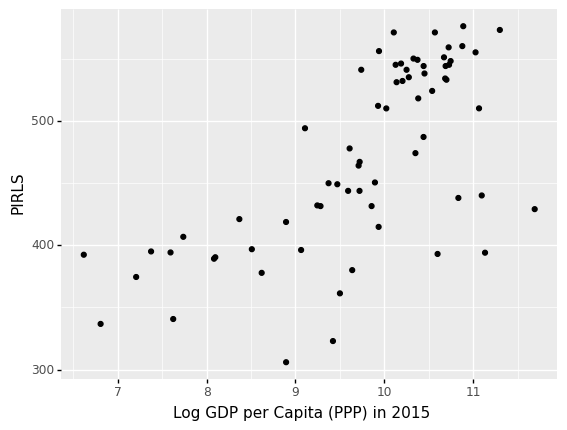

<ggplot: (99300713828)>

In [26]:
PIRLS_GDP.rename(columns={"logGDP": "Log GDP per Capita (PPP) in 2015"}, inplace=True)
ggplot(data=PIRLS_GDP) + \
    geom_point(mapping=aes(x='Log GDP per Capita (PPP) in 2015', y='PIRLS'))

## Years of Schooling and Test Scores

We will explore how much years of schooling impact test scores, taking account of the per capita income, as in Section 4.1 and Figure 6 of the original paper. In order to do that, we will use the residuals of the models we created in Q1. 

>The residuals contain what cannot be explained by income, so we can use them to see how much of what cannot be explained by income can be explained by years of schooling.<br>
>We will use the values reported for 2010.

In [38]:
TIMSS_GDP['TIMSS_residualized'] = timss_res.resid
TIMSS_GDP

,Country Name,Country Code,Series Name,Log GDP per Capita (PPP) in 2015,TIMSS,TIMSS_residualized
0,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...",9.86,406.65,-50.98
1,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...",9.01,454.00,31.69
2,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...",10.69,520.00,27.80
3,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...",10.70,511.00,18.20
4,Azerbaijan,AZE,"GDP per capita, PPP (constant 2011 internation...",9.72,465.00,12.98
...,...,...,...,...,...,...
66,Turkey,TUR,"GDP per capita, PPP (constant 2011 internation...",10.06,477.00,10.92
67,United Arab Emirates,ARE,"GDP per capita, PPP (constant 2011 internation...",11.10,437.00,-72.37
68,United States,USA,"GDP per capita, PPP (constant 2011 internation...",10.88,544.00,43.75
69,Uruguay,URY,"GDP per capita, PPP (constant 2011 internation...",9.90,424.91,-34.28


In [90]:
PIRLS_GDP['PIRLS_residualized'] = pirls_res.resid
PIRLS_GDP

,Country Name,Country Code,Series Name,logGDP,PIRLS,PIRLS_residualized
0,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...",9.86,431.44,-44.04
1,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...",9.01,NaN,NaN
2,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...",10.69,534.00,22.15
3,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...",10.70,533.00,20.52
4,Azerbaijan,AZE,"GDP per capita, PPP (constant 2011 internation...",9.72,467.00,-2.58
...,...,...,...,...,...,...
73,Turkey,TUR,"GDP per capita, PPP (constant 2011 internation...",10.06,NaN,NaN
74,United Arab Emirates,ARE,"GDP per capita, PPP (constant 2011 internation...",11.10,440.00,-89.92
75,United States,USA,"GDP per capita, PPP (constant 2011 internation...",10.88,560.00,39.68
76,Uruguay,URY,"GDP per capita, PPP (constant 2011 internation...",9.90,450.45,-26.68


We will read the file that contains `average years of schooling` data from Barro, Robert J. and Jong-Wha Lee, A New Data Set of Educational Attainment in the World, 1950-2010.

In [70]:
avgSchoolYears = pd.read_stata('BL2013_MF1599_v2.2.dta')
print(avgSchoolYears.shape)
avgSchoolYears.head()

(1898, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,WBcode,region_code
0,1.00,Algeria,"1,950.00",MF,15.00,999.00,80.68,17.56,3.75,1.45,0.46,0.30,0.16,0.85,0.74,0.09,0.01,"5,241.00",DZA,Middle East and North Africa
1,1.00,Algeria,"1,955.00",MF,15.00,999.00,81.05,17.02,3.46,1.64,0.50,0.26,0.14,0.84,0.73,0.10,0.01,"5,699.00",DZA,Middle East and North Africa
2,1.00,Algeria,"1,960.00",MF,15.00,999.00,82.61,14.31,3.07,2.75,1.05,0.32,0.17,0.88,0.71,0.16,0.01,"6,073.00",DZA,Middle East and North Africa
3,1.00,Algeria,"1,965.00",MF,15.00,999.00,80.93,14.42,4.01,4.21,1.79,0.43,0.23,1.10,0.83,0.25,0.01,"6,374.00",DZA,Middle East and North Africa
4,1.00,Algeria,"1,970.00",MF,15.00,999.00,73.64,19.22,5.23,6.69,3.26,0.34,0.18,1.55,1.16,0.39,0.01,"7,100.00",DZA,Middle East and North Africa


We will will only keep the values reported for 2010 and rename columns.

In [71]:
schoolYears = avgSchoolYears.loc[avgSchoolYears['year'] == 2010.0]
schoolYears.rename(columns={"WBcode": "Country Code"}, inplace=True)
print(schoolYears.shape)
schoolYears.head()

(146, 20)


,BLcode,country,year,sex,agefrom,ageto,lu,lp,lpc,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,Country Code,region_code
12,1.00,Algeria,"2,010.00",MF,15.00,999.00,21.12,43.90,25.88,23.21,17.08,11.77,6.66,6.68,4.19,2.12,0.37,"25,853.00",DZA,Middle East and North Africa
25,3.00,Benin,"2,010.00",MF,15.00,999.00,53.91,18.66,12.18,23.67,17.77,3.76,2.01,4.43,2.57,1.74,0.12,"5,579.00",BEN,Sub-Saharan Africa
38,4.00,Botswana,"2,010.00",MF,15.00,999.00,9.83,6.24,4.76,80.04,29.03,3.89,2.02,9.55,6.26,3.18,0.12,"1,107.00",BWA,Sub-Saharan Africa
51,6.00,Burundi,"2,010.00",MF,15.00,999.00,50.43,39.35,25.98,9.18,4.97,1.04,0.54,3.35,2.78,0.53,0.03,"5,068.00",BDI,Sub-Saharan Africa
64,7.00,Cameroon,"2,010.00",MF,15.00,999.00,20.73,47.91,31.25,28.29,15.28,3.07,1.64,6.15,4.26,1.80,0.09,"10,766.00",CMR,Sub-Saharan Africa


Now, we are going to merge the GDP per capita with years of schooling for each country...

In [72]:
gdpSchoolYears = pd.merge(gdpPerCapita, schoolYears, on='Country Code', how='inner')
print(gdpSchoolYears.shape)
gdpSchoolYears.head(2)

(138, 24)


,Country Name,Country Code,Series Name,Series Code,GDP Per Capita,BLcode,country,year,sex,agefrom,...,ls,lsc,lh,lhc,yr_sch,yr_sch_pri,yr_sch_sec,yr_sch_ter,pop,region_code
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"1,809.02",79.00,Afghanistan,"2,010.00",MF,15.00,...,16.09,8.65,6.88,3.65,3.85,2.64,1.00,0.21,"19,299.00",South Asia
1,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...",NY.GDP.PCAP.PP.KD,"10,971.29",156.00,Albania,"2,010.00",MF,15.00,...,85.78,42.90,1.59,0.93,9.93,6.48,3.40,0.05,"2,431.00",Europe and Central Asia


In [59]:
gdpSchoolYears.columns

Index(['Country Name', 'Country Code', 'Series Name', 'Series Code',
       'GDP Per Capita', 'BLcode', 'country', 'year', 'sex', 'agefrom',
       'ageto', 'lu', 'lp', 'lpc', 'ls', 'lsc', 'lh', 'lhc', 'yr_sch',
       'yr_sch_pri', 'yr_sch_sec', 'yr_sch_ter', 'pop', 'region_code'],
      dtype='object')

Keep the needed columns and merge it with the `TIMMS_GDP` scores

In [73]:
gdpSchoolYears = gdpSchoolYears[['Country Name', 'Country Code', 'Series Name', 'GDP Per Capita', 'year', 'yr_sch']]
gdpSchoolYears = pd.merge(gdpSchoolYears, TIMSS_GDP[['Country Code', 'TIMSS']], on='Country Code', how='left')
print(gdpSchoolYears.shape)
gdpSchoolYears.head()

(138, 7)


,Country Name,Country Code,Series Name,GDP Per Capita,year,yr_sch,TIMSS
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...","1,809.02","2,010.00",3.85,NaN
1,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...","10,971.29","2,010.00",9.93,NaN
2,Algeria,DZA,"GDP per capita, PPP (constant 2011 internation...","13,724.72","2,010.00",6.68,NaN
3,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...","19,101.30","2,010.00",9.51,406.65
4,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...","8,195.93","2,010.00",10.73,454.00


We merge the PIRLS as well

In [74]:
gdpSchoolYears = pd.merge(gdpSchoolYears, PIRLS_GDP[['Country Code', 'PIRLS']], on='Country Code', how='left')
gdpSchoolYears.head()

,Country Name,Country Code,Series Name,GDP Per Capita,year,yr_sch,TIMSS,PIRLS
0,Afghanistan,AFG,"GDP per capita, PPP (constant 2011 internation...","1,809.02","2,010.00",3.85,NaN,NaN
1,Albania,ALB,"GDP per capita, PPP (constant 2011 internation...","10,971.29","2,010.00",9.93,NaN,NaN
2,Algeria,DZA,"GDP per capita, PPP (constant 2011 internation...","13,724.72","2,010.00",6.68,NaN,NaN
3,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...","19,101.30","2,010.00",9.51,406.65,431.44
4,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...","8,195.93","2,010.00",10.73,454.00,NaN


As we can see there are some NaN values in the above dataset for PIRLS and TIMMS at the same time. These values we shall exclude since they are useless.

In [75]:
gdpSchoolYears = gdpSchoolYears.dropna(subset=['TIMSS', 'PIRLS'], how='all')
gdpSchoolYears.head()

,Country Name,Country Code,Series Name,GDP Per Capita,year,yr_sch,TIMSS,PIRLS
3,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...","19,101.30","2,010.00",9.51,406.65,431.44
4,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...","8,195.93","2,010.00",10.73,454.00,NaN
5,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...","43,719.50","2,010.00",11.54,520.00,534.00
6,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...","44,353.88","2,010.00",9.60,511.00,533.00
7,Bahrain,BHR,"GDP per capita, PPP (constant 2011 internation...","43,926.47","2,010.00",7.06,439.00,NaN


In [76]:
gdpSchoolYears['logGDP'] = np.log(gdpSchoolYears['GDP Per Capita'])
gdpSchoolYears

,Country Name,Country Code,Series Name,GDP Per Capita,year,yr_sch,TIMSS,PIRLS,logGDP
3,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...","19,101.30","2,010.00",9.51,406.65,431.44,9.86
4,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...","8,195.93","2,010.00",10.73,454.00,NaN,9.01
5,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...","43,719.50","2,010.00",11.54,520.00,534.00,10.69
6,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...","44,353.88","2,010.00",9.60,511.00,533.00,10.70
7,Bahrain,BHR,"GDP per capita, PPP (constant 2011 internation...","43,926.47","2,010.00",7.06,439.00,NaN,10.69
...,...,...,...,...,...,...,...,...,...
127,Turkey,TUR,"GDP per capita, PPP (constant 2011 internation...","23,388.48","2,010.00",7.05,477.00,NaN,10.06
130,United Arab Emirates,ARE,"GDP per capita, PPP (constant 2011 internation...","65,975.38","2,010.00",9.07,437.00,440.00,11.10
132,United States,USA,"GDP per capita, PPP (constant 2011 internation...","53,029.29","2,010.00",13.18,544.00,560.00,10.88
133,Uruguay,URY,"GDP per capita, PPP (constant 2011 internation...","19,831.45","2,010.00",8.17,424.91,450.45,9.90


Now we can investigate the relationship between the years spending in school and the income:

In [78]:
gdpSchoolMod = smf.ols("yr_sch ~ logGDP", data=gdpSchoolYears)
gdpSchoolResid = gdpSchoolMod.fit()
gdpSchoolResid.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yr_sch   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     110.6
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           4.74e-16
Time:                        23:34:25   Log-Likelihood:                -138.89
No. Observations:                  72   AIC:                             281.8
Df Residuals:                      70   BIC:                             286.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -10.1310      1.838     -5.512      0.000     -13.797      -6.465
logGDP         1.9594      0.186     10.515      0.000       1.588       2.331
==============================================================================
Omnibus:                        8.402   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.015   Jarque-Bera (JB):                7.855
Skew:                          -0.724   Prob(JB):                       0.0197
Kurtosis:                       3.723   Cond. No.                         92.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here, is the summary table with an `R-squared` of 0.612 which is satisfying. We also se that both p-values are 0 which means that the Intercept and the slope did not occure by chance.

Now lets calculate the residuals

In [80]:
gdpSchoolYears['Years_of_Schooling_residualized'] = gdpSchoolResid.resid
gdpSchoolYears.head()

,Country Name,Country Code,Series Name,GDP Per Capita,year,yr_sch,TIMSS,PIRLS,logGDP,Years_of_Schooling_residualized
3,Argentina,ARG,"GDP per capita, PPP (constant 2011 internation...","19,101.30","2,010.00",9.51,406.65,431.44,9.86,0.33
4,Armenia,ARM,"GDP per capita, PPP (constant 2011 internation...","8,195.93","2,010.00",10.73,454.00,NaN,9.01,3.20
5,Australia,AUS,"GDP per capita, PPP (constant 2011 internation...","43,719.50","2,010.00",11.54,520.00,534.00,10.69,0.74
6,Austria,AUT,"GDP per capita, PPP (constant 2011 internation...","44,353.88","2,010.00",9.60,511.00,533.00,10.70,-1.23
7,Bahrain,BHR,"GDP per capita, PPP (constant 2011 internation...","43,926.47","2,010.00",7.06,439.00,NaN,10.69,-3.75


then we plot them:

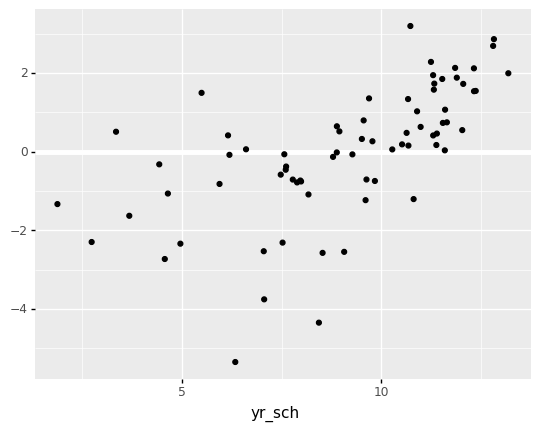

<ggplot: (317406356)>

In [81]:
ggplot(data=gdpSchoolYears) +\
    geom_hline(yintercept=0, color='white', size=2) +\
    geom_point(mapping=aes(x='yr_sch', y=gdpSchoolResid.resid))

We will merge the dataframes in order to get, for each country, the schooling years residuals and TIMSS residuals.

In [84]:
residualsTimssSchool = pd.merge(TIMSS_GDP[['Country Name','Country Code', 'TIMSS_residualized']],
                               gdpSchoolYears[['Country Code', 'Years_of_Schooling_residualized']], on='Country Code', how='inner')
residualsTimssSchool.head()

,Country Name,Country Code,TIMSS_residualized,Years_of_Schooling_residualized
0,Argentina,ARG,-50.98,0.33
1,Armenia,ARM,31.69,3.20
2,Australia,AUS,27.80,0.74
3,Austria,AUT,18.20,-1.23
4,Bahrain,BHR,-53.39,-3.75


Now, we will do a regression between schooling years residuals and TIMSS residuals and we will find what can be explained by schooling years and not by income about TIMSS scores.

In [86]:
timssSchoolMod = smf.ols("TIMSS_residualized ~ Years_of_Schooling_residualized", data=residualsTimssSchool)
timssSchoolRes = timssSchoolMod.fit()
timssSchoolRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     TIMSS_residualized   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     29.30
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           1.03e-06
Time:                        23:42:57   Log-Likelihood:                -350.69
No. Observations:                  65   AIC:                             705.4
Df Residuals:                      63   BIC:                             709.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           1.4155      6.734      0.210      0.834     -12.041      14.872
Years_of_Schooling_residualized    21.5856      3.988      5.413      0.000      13.617      29.554
==============================================================================
Omnibus:                        2.751   Durbin-Watson:                   1.890
Prob(Omnibus):                  0.253   Jarque-Bera (JB):                1.934
Skew:                           0.370   Prob(JB):                        0.380
Kurtosis:                       3.407   Cond. No.                         1.70
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, we will also plot the relationship between the residuals of the Years of schooling and the residuals of the TIMSS scores and get a simple visualization of their relationship:

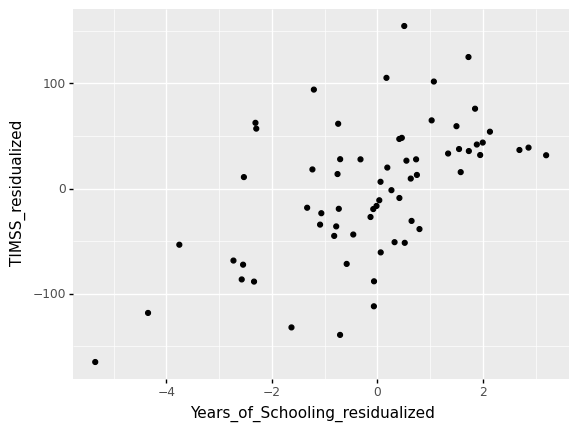

<ggplot: (315927164)>

In [87]:
ggplot(data=residualsTimssSchool) + \
    geom_point(mapping=aes(x='Years_of_Schooling_residualized', y='TIMSS_residualized'), na_rm=True)

Now we will run the same analysis for PIRLS residuals

In [92]:
residualsPirlsSchool = pd.merge(PIRLS_GDP[['Country Name','Country Code', 'PIRLS_residualized']],
                               gdpSchoolYears[['Country Code', 'Years_of_Schooling_residualized']], on='Country Code', how='inner')
residualsPirlsSchool.head()

,Country Name,Country Code,PIRLS_residualized,Years_of_Schooling_residualized
0,Argentina,ARG,-44.04,0.33
1,Armenia,ARM,NaN,3.20
2,Australia,AUS,22.15,0.74
3,Austria,AUT,20.52,-1.23
4,Bahrain,BHR,NaN,-3.75


In [93]:
pirlsSchoolMod = smf.ols("PIRLS_residualized ~ Years_of_Schooling_residualized", data=residualsPirlsSchool)
pirlsSchoolRes = pirlsSchoolMod.fit()
pirlsSchoolRes.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     PIRLS_residualized   R-squared:                       0.358
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     33.96
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           2.27e-07
Time:                        23:48:59   Log-Likelihood:                -326.38
No. Observations:                  63   AIC:                             656.8
Df Residuals:                      61   BIC:                             661.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.6948      5.509      0.126      0.900     -10.320      11.710
Years_of_Schooling_residualized    20.2531      3.475      5.828      0.000      13.304      27.202
==============================================================================
Omnibus:                       14.661   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.484
Skew:                          -0.843   Prob(JB):                     2.16e-05
Kurtosis:                       5.311   Cond. No.                         1.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

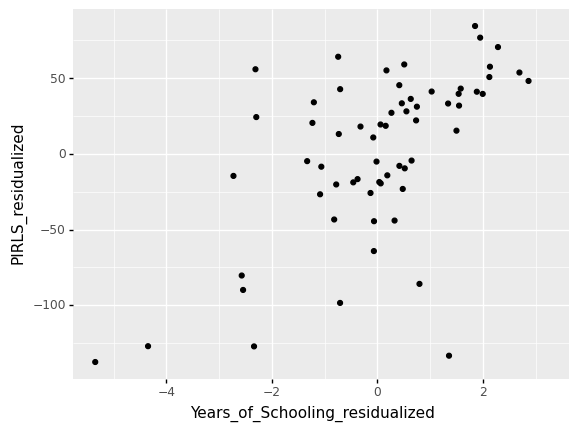

<ggplot: (315205175)>

In [94]:
ggplot(data=residualsPirlsSchool) + \
    geom_point(mapping=aes(x='Years_of_Schooling_residualized', y='PIRLS_residualized'),na_rm=True)

---

## Q3: Compare New and Previous Estimates

To see if the results of the authors of [A Rosetta Stone for Human Capital] make sense, we can compare their scales with other estimates of learning outcomes. So, let's read the file which contains learning outcome estimates from the World Bank, as reported in Altinok, Nadir, Noam Angrist, and Harry Anthony Patrinos, Global Data Set on Education Quality (1965-2015), World Bank Policy Research Working Paper, 2018. 

>Use the latest year for which estimates are available for each country.

In [95]:
estimates = pd.read_stata('HLO Panel Data (mean, thresh) - Jan 2018.dta')
estimates.rename(columns={"cntabb": "Country Code"}, inplace=True)
print(estimates.shape)
estimates.head()

(1849, 6)


,country,idcntry,Country Code,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,1965,NaN,NaN
1,"Abu Dhabi, UAE",7842,ADA,1970,NaN,NaN
2,"Abu Dhabi, UAE",7842,ADA,1975,NaN,NaN
3,"Abu Dhabi, UAE",7842,ADA,1980,NaN,NaN
4,"Abu Dhabi, UAE",7842,ADA,1985,NaN,NaN


Let us see how the data look for a random country:

In [96]:
estimates.loc[estimates['Country Code'].isin(['ARM'])]

,country,idcntry,Country Code,year,HLO,low_threshold
55,Armenia,51,ARM,1965,NaN,NaN
56,Armenia,51,ARM,1970,NaN,NaN
57,Armenia,51,ARM,1975,NaN,NaN
58,Armenia,51,ARM,1980,NaN,NaN
59,Armenia,51,ARM,1985,NaN,NaN
60,Armenia,51,ARM,1990,NaN,NaN
61,Armenia,51,ARM,1995,NaN,NaN
62,Armenia,51,ARM,2000,NaN,NaN
63,Armenia,51,ARM,2005,482.68,87.98
64,Armenia,51,ARM,2010,469.07,86.13


We can see that we have some nan values we need to drop.

In [209]:
estimates.dropna(inplace=True)
estimates.reset_index(drop=True, inplace=True)
print(estimates.shape)
estimates.head()

(626, 6)


,country,idcntry,Country Code,year,HLO,low_threshold
0,"Abu Dhabi, UAE",7842,ADA,2010,428.68,73.83
1,"Abu Dhabi, UAE",7842,ADA,2015,437.07,73.75
2,Albania,8,ALB,2000,400.65,57.75
3,Albania,8,ALB,2005,399.32,60.15
4,Albania,8,ALB,2010,402.75,61.32


We are going to make a set containing the latest yearly report for each country. 2015 is the most recent one we have info. 

These are all the countries together:

In [191]:
countries = pd.DataFrame(estimates['Country Code'].unique(), columns=['Country Code'])
countries

,Country Code
0,ADA
1,ALB
2,DZA
3,ARG
4,ARB
...,...
153,VNM
154,YEM
155,ZMB
156,ZAN


Get the number of countries and the unique number ot years and sort the in a decreasing order.

In [252]:
numberOfCountries = len(estimates['Country Code'].unique())
years = np.array(estimates['year'].unique())
years[::-1].sort()

array([2015, 2010, 2005, 2000, 1995, 1990, 1985, 1980, 1975, 1970],
      dtype=int16)

Create a script that gets adds recursively the counties in the finalEstinate based on the year. The script stops when all the countries have been added.

In [260]:
runningYear = 0
finalEstimates = estimates.loc[estimates['year'] == years[runningYear]]
estimates2015.reset_index(drop=True, inplace=True)

while len(finalEstimates) != numberOfCountries:
    #get next year
    runningYear += 1
    #Make a dataframe for the new countries
    newCountries = pd.DataFrame(finalEstimates['Country Code'].unique(), columns=['Country Code'])
    #filter them out from all the countries
    countriesFiltered = countries.merge(newCountries,how='left',indicator=True).loc[lambda x:x['_merge']!='both']
    #merge them based on all estimates
    countriesFiltered = pd.merge(countriesFiltered, estimates, on='Country Code', how='inner')
    #get the estimates only for the running year
    newEstimates = countriesFiltered.loc[countriesFiltered['year'] == years[runningYear]]
    #concat the new estimated with the previous ones
    finalEstimates = pd.concat([finalEstimates, newEstimates])

print(finalEstimates.shape)
finalEstimates.reset_index(drop=True, inplace=True)
finalEstimates = finalEstimates[['Country Code', 'country', 'year', 'HLO', 'low_threshold']]
finalEstimates

(158, 7)


,Country Code,country,year,HLO,low_threshold
0,ADA,"Abu Dhabi, UAE",2015,437.07,73.75
1,ALB,Albania,2015,436.73,70.65
2,DZA,Algeria,2015,375.14,51.31
3,ARG,Argentina,2015,429.38,70.86
4,ARB,"Argentina, Buenos Aires",2015,414.19,67.75
...,...,...,...,...,...
153,LKA,Sri Lanka,2000,292.30,41.90
154,BFR,Belgium French,1995,500.39,93.32
155,BOL,Bolivia Plurinational State of,1995,370.40,53.61
156,NGA,Nigeria,1995,241.18,45.02


Now merge with TIMSS and PIRLS 

In [263]:
estimatesScore = pd.merge(countryData, finalEstimates, on='Country Code', how='inner')
estimatesScore = estimatesScore[['Country', 'Country Code', 'Percent Above Math Benchmark (400 on TIMSS Scale)', 
                                'Percent Above Reading Benchmark (400 on PIRLS Scale)','year', 'low_threshold']]

estimatesScore.rename(columns={"Percent Above Math Benchmark (400 on TIMSS Scale)": "TIMSS"}, inplace=True)
estimatesScore.rename(columns={"Percent Above Reading Benchmark (400 on PIRLS Scale)": "PIRLS"}, inplace=True)
print(estimatesScore.shape)
estimatesScore.head()

(77, 6)


,Country,Country Code,TIMSS,PIRLS,year,low_threshold
0,U.A.E.,ARE,64.00,63.98,2015,80.84
1,Argentina,ARG,51.00,66.00,2015,70.86
2,Armenia,ARM,71.51,NaN,2010,86.13
3,Australia,AUS,90.00,92.93,2015,91.53
4,Austria,AUT,95.30,97.10,2015,88.51


Set the values we will use in the Spearman test. The results between the previous and the new estimates of the TIMSS are:

In [265]:
X = estimatesScore.low_threshold.values
Y = estimatesScore.TIMSS.values
Z = estimatesScore.PIRLS.values
print('Spearman for TIMSS:', stats.spearmanr(X,Y, nan_policy='omit'))

Spearman for TIMSS: SpearmanrResult(correlation=0.8973790562032016, pvalue=1.687973764124364e-25)


- As we can see, the correlation is strong(almost 0.9) this means that there is an important assosiation between the results. 
- The fact that p-value is very small indicates that the correlation value is not accidental.

Let's a plot it order to see a visual representation of the correlation

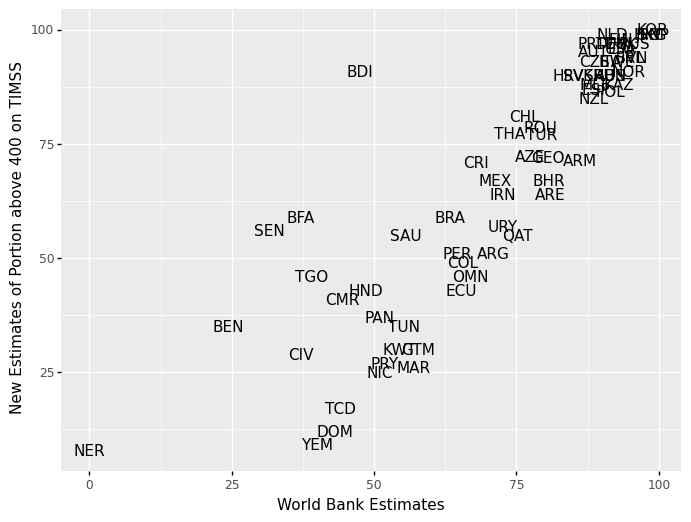

<ggplot: (316544844)>

In [267]:
ggplot(data=estimatesScore, mapping=aes(x='low_threshold', y='TIMSS')) +\
    labs(x='World Bank Estimates', y='New Estimates of Portion above 400 on TIMSS') +\
    geom_text(mapping=aes(label='Country Code'), na_rm=True) +\
    theme(figure_size=(8, 6))

We do the same for the PIRLS

In [268]:
print('Spearman for PIRLS:', stats.spearmanr(X,Z, nan_policy='omit'))

Spearman for PIRLS: SpearmanrResult(correlation=0.9045173418249433, pvalue=5.290584772193416e-25)


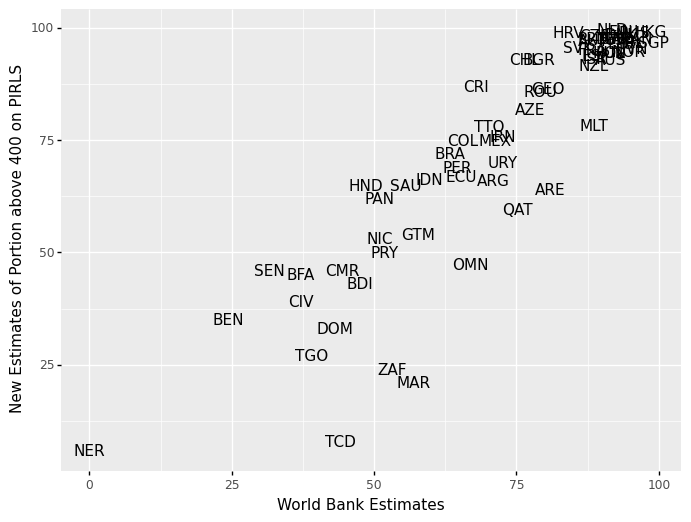

<ggplot: (315782488)>

In [270]:
ggplot(data=estimatesScore, mapping=aes(x='low_threshold', y='PIRLS')) +\
    labs(x='World Bank Estimates', y='New Estimates of Portion above 400 on PIRLS') +\
    geom_text(mapping=aes(label='Country Code'), na_rm=True) +\
    theme(figure_size=(8, 6))

---

## Q4: Skills Intensity

Let's study the relationship between the skills of the people in each country and the value of its exports as described in Section 4.2 of the original paper. Lets read the file containing the data.

In [4]:
usa = pd.read_csv('usa_00001.csv')
print(usa.shape)
usa.head()

(371618, 15)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.00,2000000000014,17,1,1,618.00,8,81,1,10,3130,797
1,2000,200004,1,600.00,2000000000014,17,1,2,684.00,8,81,1,10,7210,467
2,2000,200004,2,600.00,2000000000024,48,1,1,618.00,6,62,1,10,8030,359
3,2000,200004,2,600.00,2000000000024,48,1,2,609.00,6,62,3,30,5240,617
4,2000,200004,2,600.00,2000000000024,48,1,3,621.00,6,62,1,10,9360,877


Then we group the dataset by Industry:

In [11]:
usaGrouped = usa.groupby(['IND']).sum()
print(usaGrouped.shape)
usaGrouped.head()

(266, 14)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010
IND,,,,,,,,,,,,,,
0,287412000,28741774824,11347780503,"105,886,600.00",287412113478381696,3976219,143905,405211,"108,371,644.00",441309,4611907,186255,1862550,1425563520
17,4108000,410808216,168770778,"1,358,700.00",4108001687715996,55754,2058,3758,"1,391,515.00",11546,118815,3349,33540,6728580
18,2200000,220004400,86906943,"714,200.00",2200000869073830,35960,1100,1827,"723,084.00",6574,67690,1537,15392,2961705
19,108000,10800216,4782790,"32,450.00",108000047828116,1563,54,78,"32,080.00",428,4376,80,800,185445
27,402000,40200804,15975850,"142,650.00",402000159759304,5862,201,311,"147,320.00",1132,11669,270,2708,1290575


We create the dataset with the college graduates. We need Educ >= 10

In [25]:
collegeGrads = usa.loc[usa['EDUC'] >= 10]
print(collegeGrads.shape)
collegeGrads.head()

(69972, 15)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
8,2000,200004,5,600.00,2000000000054,12,1,1,603.00,10,101,3,30,700,959
13,2000,200004,7,600.00,2000000000074,6,1,1,628.00,10,101,1,10,3300,819
14,2000,200004,7,600.00,2000000000074,6,1,2,708.00,11,114,1,10,2600,657
20,2000,200004,11,600.00,2000000000114,17,1,2,518.00,11,116,1,10,2010,837
21,2000,200004,12,200.00,2000000000124,11,1,1,214.00,10,101,3,30,30,668


...and the dataset with the high school graduates. We need EDUC >= 6

In [38]:
highschoolGrads = usa.loc[usa['EDUC'] >= 6 ].copy()
print(highschoolGrads.shape)
highschoolGrads.head()

(242038, 15)


,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,IND
0,2000,200004,1,600.00,2000000000014,17,1,1,618.00,8,81,1,10,3130,797
1,2000,200004,1,600.00,2000000000014,17,1,2,684.00,8,81,1,10,7210,467
2,2000,200004,2,600.00,2000000000024,48,1,1,618.00,6,62,1,10,8030,359
3,2000,200004,2,600.00,2000000000024,48,1,2,609.00,6,62,3,30,5240,617
4,2000,200004,2,600.00,2000000000024,48,1,3,621.00,6,62,1,10,9360,877


We group the dataset by Industry. We keep the needed columns but we rename it.

In [30]:
collegeGrads = collegeGrads.groupby(['IND']).sum()
collegeGrads = collegeGrads[['PERWT']]
collegeGrads.rename(columns={"PERWT": "PERWT COLLEGE"}, inplace=True)
print(collegeGrads.shape)
collegeGrads.head()

(265, 1)


,PERWT COLLEGE
IND,
0,"5,117,532.00"
17,"133,389.00"
18,"70,935.00"
19,"10,095.00"
27,"7,917.00"


We merge the college dataset with the initial grouped dataset to link each PERWT COLLEGE value with its corresponding PERWT value:

In [31]:
collegeGrads = pd.merge(collegeGrads, usaGrouped, on='IND', how='inner')
print(collegeGrads.shape)
collegeGrads.head()

(265, 15)


,PERWT COLLEGE,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010
IND,,,,,,,,,,,,,,,
0,"5,117,532.00",287412000,28741774824,11347780503,"105,886,600.00",287412113478381696,3976219,143905,405211,"108,371,644.00",441309,4611907,186255,1862550,1425563520
17,"133,389.00",4108000,410808216,168770778,"1,358,700.00",4108001687715996,55754,2058,3758,"1,391,515.00",11546,118815,3349,33540,6728580
18,"70,935.00",2200000,220004400,86906943,"714,200.00",2200000869073830,35960,1100,1827,"723,084.00",6574,67690,1537,15392,2961705
19,"10,095.00",108000,10800216,4782790,"32,450.00",108000047828116,1563,54,78,"32,080.00",428,4376,80,800,185445
27,"7,917.00",402000,40200804,15975850,"142,650.00",402000159759304,5862,201,311,"147,320.00",1132,11669,270,2708,1290575


And now we calculate the weighted average of the college grads

In [32]:
collegeGrads['COLLEGE_WAVG'] = (collegeGrads['PERWT COLLEGE']) / collegeGrads['PERWT'] 
collegeGrads.head()

,PERWT COLLEGE,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,COLLEGE_WAVG
IND,,,,,,,,,,,,,,,,
0,"5,117,532.00",287412000,28741774824,11347780503,"105,886,600.00",287412113478381696,3976219,143905,405211,"108,371,644.00",441309,4611907,186255,1862550,1425563520,0.05
17,"133,389.00",4108000,410808216,168770778,"1,358,700.00",4108001687715996,55754,2058,3758,"1,391,515.00",11546,118815,3349,33540,6728580,0.10
18,"70,935.00",2200000,220004400,86906943,"714,200.00",2200000869073830,35960,1100,1827,"723,084.00",6574,67690,1537,15392,2961705,0.10
19,"10,095.00",108000,10800216,4782790,"32,450.00",108000047828116,1563,54,78,"32,080.00",428,4376,80,800,185445,0.31
27,"7,917.00",402000,40200804,15975850,"142,650.00",402000159759304,5862,201,311,"147,320.00",1132,11669,270,2708,1290575,0.05


We follow the same procedure for high scholl grads

In [39]:
highschoolGrads = highschoolGrads.groupby(['IND']).sum()
highschoolGrads = highschoolGrads[['PERWT']]
highschoolGrads.rename(columns={"PERWT": "PERWT HIGH SCHOOL"}, inplace=True)
highschoolGrads = pd.merge(highschoolGrads, usaGrouped, on='IND', how='inner')
highschoolGrads['HIGH_SCHOOL_WAVG'] = highschoolGrads['PERWT HIGH SCHOOL'] / highschoolGrads['PERWT'] 
print(highschoolGrads.shape)
highschoolGrads.head()

(266, 16)


,PERWT HIGH SCHOOL,YEAR,SAMPLE,SERIAL,HHWT,CLUSTER,STRATA,GQ,PERNUM,PERWT,EDUC,EDUCD,EMPSTAT,EMPSTATD,OCC2010,HIGH_SCHOOL_WAVG
IND,,,,,,,,,,,,,,,,
0,"28,314,555.00",287412000,28741774824,11347780503,"105,886,600.00",287412113478381696,3976219,143905,405211,"108,371,644.00",441309,4611907,186255,1862550,1425563520,0.26
17,"806,904.00",4108000,410808216,168770778,"1,358,700.00",4108001687715996,55754,2058,3758,"1,391,515.00",11546,118815,3349,33540,6728580,0.58
18,"516,534.00",2200000,220004400,86906943,"714,200.00",2200000869073830,35960,1100,1827,"723,084.00",6574,67690,1537,15392,2961705,0.71
19,"29,645.00",108000,10800216,4782790,"32,450.00",108000047828116,1563,54,78,"32,080.00",428,4376,80,800,185445,0.92
27,"112,982.00",402000,40200804,15975850,"142,650.00",402000159759304,5862,201,311,"147,320.00",1132,11669,270,2708,1290575,0.77


And finally we can create a dataset named `skills_intensity_industry` with the high school and college weighted averages for each industry:

In [40]:
skillsIntensityIndustry = pd.merge(highschoolGrads[['HIGH_SCHOOL_WAVG']], collegeGrads[['COLLEGE_WAVG']], on='IND', how='left')
print(skillsIntensityIndustry.shape)
skillsIntensityIndustry.head()

(266, 2)


,HIGH_SCHOOL_WAVG,COLLEGE_WAVG
IND,,
0,0.26,0.05
17,0.58,0.10
18,0.71,0.10
19,0.92,0.31
27,0.77,0.05


The data that we have so far is from 2000. But the industry codes for 1990 and 2000 are not the same and we need to use data from 1990. So, let's read the file that maps industry codes of 1990 and 2000.

In [42]:
crosswalkInd = pd.read_stata('cw_ind2000_ind1990ddx.dta')
crosswalkInd.rename(columns={"ind2000": "IND"}, inplace=True)
print(crosswalkInd.shape)
crosswalkInd.head()

(712, 3)


,IND,ind1990ddx,weight
0,17,10,0.99
1,17,31,0.00
2,17,121,0.00
3,17,561,0.00
4,18,11,0.99


In [43]:
skillsIntensityIndustry = pd.merge(skillsIntensityIndustry, crosswalkInd, on='IND', how='inner')
print(skillsIntensityIndustry.shape)
skillsIntensityIndustry.head()

(712, 5)


,IND,HIGH_SCHOOL_WAVG,COLLEGE_WAVG,ind1990ddx,weight
0,17,0.58,0.10,10,0.99
1,17,0.58,0.10,31,0.00
2,17,0.58,0.10,121,0.00
3,17,0.58,0.10,561,0.00
4,18,0.71,0.10,11,0.99


We will recalculate all the weighted averages in `skillsIntensityIndustry` dataset:

In [46]:
skillsIntensityIndustry['NEW_COLLEGE_WAVG'] = skillsIntensityIndustry['COLLEGE_WAVG'] * skillsIntensityIndustry['weight']
skillsIntensityIndustry['NEW_HIGH_SCHOOL_WAVG'] = skillsIntensityIndustry['HIGH_SCHOOL_WAVG'] * skillsIntensityIndustry['weight']
skillsIntensityIndustry.rename(columns={"ind1990ddx": "INDUSTRY"}, inplace=True)
print(skillsIntensityIndustry.shape)
skillsIntensityIndustry.head()

(712, 7)


,IND,HIGH_SCHOOL_WAVG,COLLEGE_WAVG,INDUSTRY,weight,NEW_COLLEGE_WAVG,NEW_HIGH_SCHOOL_WAVG
0,17,0.58,0.10,10,0.99,0.10,0.58
1,17,0.58,0.10,31,0.00,0.00,0.00
2,17,0.58,0.10,121,0.00,0.00,0.00
3,17,0.58,0.10,561,0.00,0.00,0.00
4,18,0.71,0.10,11,0.99,0.10,0.71


Now, we have can group our datset by Industry again:

In [47]:
skillsIntensityIndustry = skillsIntensityIndustry.groupby(['INDUSTRY'])['NEW_COLLEGE_WAVG', 'NEW_HIGH_SCHOOL_WAVG'].sum()
print(skillsIntensityIndustry.shape)
skillsIntensityIndustry.head

(222, 2)


<bound method NDFrame.head of           NEW_COLLEGE_WAVG  NEW_HIGH_SCHOOL_WAVG
INDUSTRY                                        
10                    0.15                  0.81
11                    0.10                  0.71
20                    0.56                  2.01
31                    0.35                  1.06
32                    0.17                  0.65
...                    ...                   ...
921                   0.35                  0.99
922                   0.40                  0.87
930                   0.34                  0.64
931                   0.41                  1.03
932                   0.30                  0.91

[222 rows x 2 columns]>

We are going to read the file containing the exports of different countries in 2018 of different industry sectors:

In [67]:
baciExports = pd.read_csv('BACI_HS17_Y2018_V202001.csv')
baciExports.rename(columns={"t": "YEAR"}, inplace=True)
baciExports.rename(columns={"i": "EXPORTER"}, inplace=True)
baciExports.rename(columns={"j": "IMPORTER"}, inplace=True)
baciExports.rename(columns={"k": "HS6"}, inplace=True)
baciExports.rename(columns={"v": "TRADE FLOW"}, inplace=True)
baciExports.rename(columns={"q": "QUANTITY"}, inplace=True)
print(baciExports.shape)
baciExports.head()

(7738903, 6)


,YEAR,EXPORTER,IMPORTER,HS6,TRADE FLOW,QUANTITY
0,2018,4,24,845420,101.40,26.00
1,2018,4,24,848180,2.33,0.01
2,2018,4,31,570110,1.60,0.04
3,2018,4,32,340319,8.70,0.11
4,2018,4,32,610910,1.10,0.01


We will read the following file in order to map the `HS 6-digit` code with `Standard Industrial Codes (SIC) SIC87` industry codes.

In [63]:
crosswalkHS6 = pd.read_stata('cw_hs6_sic87dd.dta')
print(crosswalkHS6.shape)
crosswalkHS6.head()

(6752, 4)


,hs6,sic87dd,share,weights_method
0,"10,110.00",272.00,1.00,no weights needed
1,"10,111.00",272.00,1.00,no weights needed
2,"10,119.00",272.00,1.00,no weights needed
3,"10,120.00",272.00,1.00,no weights needed
4,"10,190.00",272.00,1.00,no weights needed


In [64]:
crosswalkHS6[['sic87dd']] = crosswalkHS6[['sic87dd']].fillna(value=0)
crosswalkHS6['sic87dd'] = crosswalkHS6['sic87dd'].astype(int) 
crosswalkHS6['hs6'] = crosswalkHS6['hs6'].astype(int) 
crosswalkHS6.rename(columns={"hs6": "HS6"}, inplace=True)
crosswalkHS6.rename(columns={"sic87dd": "INDUSTRY"}, inplace=True)
print(crosswalkHS6.shape)
crosswalkHS6.head()

(6752, 4)


,HS6,INDUSTRY,share,weights_method
0,10110,272,1.00,no weights needed
1,10111,272,1.00,no weights needed
2,10119,272,1.00,no weights needed
3,10120,272,1.00,no weights needed
4,10190,272,1.00,no weights needed


Let's join the two dataframes that contain the two different codes (`hs6`, `sic87dd`).

In [68]:
baci = pd.merge(baciExports, crosswalkHS6, on='HS6', how='inner')
print(baci.shape)
baci.head()

(9631896, 9)


,YEAR,EXPORTER,IMPORTER,HS6,TRADE FLOW,QUANTITY,INDUSTRY,share,weights_method
0,2018,4,24,845420,101.40,26.00,3321,0.64,trade-based
1,2018,4,24,845420,101.40,26.00,3559,0.36,trade-based
2,2018,36,288,845420,16.38,0.18,3321,0.64,trade-based
3,2018,36,288,845420,16.38,0.18,3559,0.36,trade-based
4,2018,36,360,845420,7.11,0.02,3321,0.64,trade-based


Now, we need to adjust the value of the trade flow  using the `share` column.

In [70]:
baci['NEW_TF_VALUE'] = baci['TRADE FLOW'] * baci['share']
print(baci.shape)
baci.head()

(9631896, 10)


,YEAR,EXPORTER,IMPORTER,HS6,TRADE FLOW,QUANTITY,INDUSTRY,share,weights_method,NEW_TF_VALUE
0,2018,4,24,845420,101.40,26.00,3321,0.64,trade-based,64.53
1,2018,4,24,845420,101.40,26.00,3559,0.36,trade-based,36.87
2,2018,36,288,845420,16.38,0.18,3321,0.64,trade-based,10.43
3,2018,36,288,845420,16.38,0.18,3559,0.36,trade-based,5.96
4,2018,36,360,845420,7.11,0.02,3321,0.64,trade-based,4.52


After that, we group the trade flow by exporter and SIC87 industry code, so that we have the total value per exporter and industry.

In [115]:
exports = baci.groupby(['EXPORTER', 'INDUSTRY'])['NEW_TF_VALUE'].sum().to_frame().reset_index()
print(exports.shape)
exports

(67827, 3)


,EXPORTER,INDUSTRY,NEW_TF_VALUE
0,4,0,231.21
1,4,119,"68,290.43"
2,4,131,"39,698.89"
3,4,132,43.99
4,4,134,380.46
...,...,...,...
67822,894,3996,1.89
67823,894,3999,"4,143.75"
67824,894,9100,"45,340.13"
67825,894,9200,"2,643.83"


Now, we read the file that will help to map the SIC87 industry codes to the 1990 census industry codes.

In [96]:
crosswalk90 = pd.read_stata('cw_sic87_ind1990ddx.dta')
crosswalk90.rename(columns={"ind1990ddx": "INDUSTRY1990"}, inplace=True)
crosswalk90.rename(columns={"sic87": "INDUSTRY"}, inplace=True)
print(crosswalk90.shape)
crosswalk90.head()

(1004, 2)


,INDUSTRY1990,INDUSTRY
0,10,111
1,10,112
2,10,115
3,10,116
4,10,119


In [116]:
exports = pd.merge(exports, crosswalk90, on='INDUSTRY', how='inner')
print(exports.shape)
exports.head()

(67052, 4)


,EXPORTER,INDUSTRY,NEW_TF_VALUE,INDUSTRY1990
0,4,119,"68,290.43",10
1,8,119,480.88,10
2,12,119,104.19,10
3,16,119,2.33,10
4,20,119,0.14,10


Exporter countries are given with the ISO 3-digit country codes, but we need to three letter country code that is used in the rest of our data. To do the mapping we will read the following file.

In [117]:
countryISOCodes = pd.read_csv('country_codes_V202001.csv', encoding = "ISO-8859-1")
countryISOCodes.rename(columns={"country_code": "EXPORTER"}, inplace=True)
print(countryISOCodes.shape)
countryISOCodes.head()

(227, 5)


,EXPORTER,country_name_abbreviation,country_name_full,iso_2digit_alpha,iso_3digit_alpha
0,4,Afghanistan,Afghanistan,AF,AFG
1,8,Albania,Albania,AL,ALB
2,12,Algeria,Algeria,DZ,DZA
3,16,American Samoa,American Samoa,AS,ASM
4,20,Andorra,Andorra,AD,AND


In [118]:
exports = pd.merge(exports, countryISOCodes, on='EXPORTER', how='inner')
exports.rename(columns={"iso_3digit_alpha": "Country Code"}, inplace=True)
print(exports.shape)
exports.head()

(67052, 8)


,EXPORTER,INDUSTRY,NEW_TF_VALUE,INDUSTRY1990,country_name_abbreviation,country_name_full,iso_2digit_alpha,Country Code
0,4,119,"68,290.43",10,Afghanistan,Afghanistan,AF,AFG
1,4,131,"39,698.89",10,Afghanistan,Afghanistan,AF,AFG
2,4,132,43.99,10,Afghanistan,Afghanistan,AF,AFG
3,4,134,380.46,10,Afghanistan,Afghanistan,AF,AFG
4,4,139,"13,308.07",10,Afghanistan,Afghanistan,AF,AFG


Now we can join the exports DataFrame with the skills_intensity_industry DataFrame and the country_scores DataFrame, so that you get for each country, value of exports per industry and the weighted average of high school graduates and college graduates.

In [119]:
final = pd.merge(exports, countryData, on='Country Code', how='inner')
final.rename(columns={"INDUSTRY": "INDUSTRY2000"}, inplace=True)
final.rename(columns={"INDUSTRY1990": "INDUSTRY"}, inplace=True)
print(final.shape)
final.head()

(30370, 13)


,EXPORTER,INDUSTRY2000,NEW_TF_VALUE,INDUSTRY,country_name_abbreviation,country_name_full,iso_2digit_alpha,Country Code,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),"Median Math Score (TIMSS Scale, 4th Grade)","Median Reading Score (PIRLS Scale, 4th Grade)"
0,31,119,"2,312.35",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00
1,31,131,"80,377.09",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00
2,31,132,"12,685.51",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00
3,31,134,"29,591.40",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00
4,31,139,"5,056.14",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00


In [120]:
final = pd.merge(final, skillsIntensityIndustry, on='INDUSTRY', how='inner')
final.rename(columns={"Country Code": "CountryCode"}, inplace=True)
final.rename(columns={"Median Math Score (TIMSS Scale, 4th Grade)": "TIMSS"}, inplace=True)
final.rename(columns={"Median Reading Score (PIRLS Scale, 4th Grade)": "PIRLS"}, inplace=True)
print(final.shape)
final.head()

(30370, 15)


,EXPORTER,INDUSTRY2000,NEW_TF_VALUE,INDUSTRY,country_name_abbreviation,country_name_full,iso_2digit_alpha,CountryCode,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),TIMSS,PIRLS,NEW_COLLEGE_WAVG,NEW_HIGH_SCHOOL_WAVG
0,31,119,"2,312.35",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81
1,31,131,"80,377.09",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81
2,31,132,"12,685.51",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81
3,31,134,"29,591.40",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81
4,31,139,"5,056.14",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81


Let's divide `TIMSS` and `PIRLS` score by 1000 and calculate the logged value of the trade flow.

In [122]:
final['TIMSS_DIV'] = final['TIMSS']  / 1000
final['PIRLS_DIV'] = final['PIRLS'] / 1000
final.head()

,EXPORTER,INDUSTRY2000,NEW_TF_VALUE,INDUSTRY,country_name_abbreviation,country_name_full,iso_2digit_alpha,CountryCode,Country,Percent Above Math Benchmark (400 on TIMSS Scale),Percent Above Reading Benchmark (400 on PIRLS Scale),TIMSS,PIRLS,NEW_COLLEGE_WAVG,NEW_HIGH_SCHOOL_WAVG,TIMSS_DIV,PIRLS_DIV
0,31,119,"2,312.35",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81,0.47,0.47
1,31,131,"80,377.09",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81,0.47,0.47
2,31,132,"12,685.51",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81,0.47,0.47
3,31,134,"29,591.40",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81,0.47,0.47
4,31,139,"5,056.14",10,Azerbaijan,Azerbaijan,AZ,AZE,Azerbaijan,72.28,81.86,465.00,467.00,0.15,0.81,0.47,0.47


Now, we are going to run the first regression analysis: we will investigate the relationship between the logged value of exports in the country and the TIMSS score possessed by the college graduates in the country:

In [123]:
timssCollege = smf.ols("np.log(NEW_TF_VALUE) ~ TIMSS:NEW_COLLEGE_WAVG + C(INDUSTRY) + C(CountryCode)", data=final)
timssCollege = timssCollege.fit()
timssCollege.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(NEW_TF_VALUE)   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     280.0
Date:                  Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                          00:30:10   Log-Likelihood:                -63026.
No. Observations:                 27490   AIC:                         1.264e+05
Df Residuals:                     27338   BIC:                         1.276e+05
Df Model:                           151                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  9.9422      0.162     61.259      0.000       9.624      10.260
C(INDUSTRY)[T.11]         -2.4785      0.139    -17.892      0.000      -2.750      -2.207
C(INDUSTRY)[T.31]         -0.1795      0.324     -0.553      0.580      -0.816       0.456
C(INDUSTRY)[T.32]         -0.6361      0.193     -3.294      0.001      -1.015      -0.258
C(INDUSTRY)[T.40]         -0.9261      0.148     -6.237      0.000      -1.217      -0.635
C(INDUSTRY)[T.41]         -1.0288      0.282     -3.643      0.000      -1.582      -0.475
C(INDUSTRY)[T.42]          1.9990      0.374      5.352      0.000       1.267       2.731
C(INDUSTRY)[T.50]         -0.5256      0.142     -3.699      0.000      -0.804      -0.247
C(INDUSTRY)[T.100]         3.0076      0.231     13.046      0.000       2.556       3.459
C(INDUSTRY)[T.101]         1.1434      0.160      7.164      0.000       0.831       1.456
C(INDUSTRY)[T.102]         1.5264      0.152     10.039      0.000       1.228       1.824
C(INDUSTRY)[T.110]         0.4860      0.137      3.553      0.000       0.218       0.754
C(INDUSTRY)[T.111]         2.1740      0.301      7.215      0.000       1.583       2.765
C(INDUSTRY)[T.112]         1.4080      0.155      9.079      0.000       1.104       1.712
C(INDUSTRY)[T.120]         0.1484      0.150      0.992      0.321      -0.145       0.442
C(INDUSTRY)[T.121]         0.6988      0.119      5.888      0.000       0.466       0.931
C(INDUSTRY)[T.130]        -1.3117      0.191     -6.866      0.000      -1.686      -0.937
C(INDUSTRY)[T.132]        -1.7212      0.182     -9.469      0.000      -2.078      -1.365
C(INDUSTRY)[T.141]        -0.0634      0.302     -0.210      0.834      -0.656       0.529
C(INDUSTRY)[T.142]         0.1727      0.144      1.198      0.231      -0.110       0.455
C(INDUSTRY)[T.150]         0.2009      0.169      1.187      0.235      -0.131       0.533
C(INDUSTRY)[T.151]        -0.7914      0.138     -5.719      0.000      -1.063      -0.520
C(INDUSTRY)[T.152]        -0.4180      0.141     -2.969      0.003      -0.694      -0.142
C(INDUSTRY)[T.160]         1.5077      0.230      6.562      0.000       1.057       1.958
C(INDUSTRY)[T.161]        -0.5404      0.133     -4.075      0.000      -0.800      -0.280
C(INDUSTRY)[T.162]        -0.7699      0.164     -4.705      0.000      -1.091      -0.449
C(INDUSTRY)[T.171]        -4.7647      0.327    -14.579      0.000      -5.405      -4.124
C(INDUSTRY)[T.172]        -4.6736      0.402    -11.633      0.000      -5.461      -3.886
C(INDUSTRY)[T.180]         0.6480      0.172      3.768      0.000       0.311       0.985
C(INDUSTRY)[T.181]        -0.1261      0.277     -0.455      0.649      -0.669       0.417
C(INDUSTRY)[T.182]         0.9451      0.172      5.488   

> The R-squared value here is 0.607 . This indicates that the model does not explain all the variability of the response data around its mean very successfully and that we could probably use a better model. <br> The Intercept coefficient here is 9.9422 . This means that if the weighted average of the college graduates that are adequate in math was equal to 0, then the logged value of the trade flow would be 2^9,9422 .

Next, we are going to run a regression analysis, where we will investigate the relationship between the logged value of exports in the country and the PIRLS score possessed by the college graduates in the country:

In [124]:
pirlsCollege = smf.ols("np.log(NEW_TF_VALUE) ~ PIRLS:NEW_COLLEGE_WAVG + C(INDUSTRY) + C(CountryCode)", data=final)
pirlsCollege = pirlsCollege.fit()
pirlsCollege.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(NEW_TF_VALUE)   R-squared:                       0.616
Model:                              OLS   Adj. R-squared:                  0.614
Method:                   Least Squares   F-statistic:                     284.3
Date:                  Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                          00:30:41   Log-Likelihood:                -60244.
No. Observations:                 26401   AIC:                         1.208e+05
Df Residuals:                     26252   BIC:                         1.220e+05
Df Model:                           148                                         
Covariance Type:              nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 10.0597      0.166     60.455      0.000       9.734      10.386
C(INDUSTRY)[T.11]         -2.4886      0.141    -17.675      0.000      -2.765      -2.213
C(INDUSTRY)[T.31]          0.0077      0.335      0.023      0.982      -0.650       0.665
C(INDUSTRY)[T.32]         -0.7544      0.196     -3.849      0.000      -1.139      -0.370
C(INDUSTRY)[T.40]         -0.7990      0.150     -5.326      0.000      -1.093      -0.505
C(INDUSTRY)[T.41]         -0.9946      0.282     -3.526      0.000      -1.547      -0.442
C(INDUSTRY)[T.42]          2.0959      0.412      5.082      0.000       1.288       2.904
C(INDUSTRY)[T.50]         -0.5823      0.146     -3.977      0.000      -0.869      -0.295
C(INDUSTRY)[T.100]         2.9389      0.235     12.500      0.000       2.478       3.400
C(INDUSTRY)[T.101]         1.0745      0.163      6.597      0.000       0.755       1.394
C(INDUSTRY)[T.102]         1.5027      0.154      9.732      0.000       1.200       1.805
C(INDUSTRY)[T.110]         0.4839      0.138      3.505      0.000       0.213       0.755
C(INDUSTRY)[T.111]         2.1208      0.305      6.950      0.000       1.523       2.719
C(INDUSTRY)[T.112]         1.4321      0.158      9.084      0.000       1.123       1.741
C(INDUSTRY)[T.120]         0.2290      0.152      1.502      0.133      -0.070       0.528
C(INDUSTRY)[T.121]         0.6646      0.121      5.513      0.000       0.428       0.901
C(INDUSTRY)[T.130]        -1.5606      0.191     -8.190      0.000      -1.934      -1.187
C(INDUSTRY)[T.132]        -1.9657      0.186    -10.551      0.000      -2.331      -1.601
C(INDUSTRY)[T.141]        -0.1253      0.306     -0.409      0.683      -0.726       0.475
C(INDUSTRY)[T.142]         0.0476      0.146      0.326      0.744      -0.239       0.334
C(INDUSTRY)[T.150]        -0.0137      0.175     -0.078      0.938      -0.358       0.330
C(INDUSTRY)[T.151]        -0.9094      0.150     -6.073      0.000      -1.203      -0.616
C(INDUSTRY)[T.152]        -0.5397      0.144     -3.757      0.000      -0.821      -0.258
C(INDUSTRY)[T.160]         1.6924      0.232      7.284      0.000       1.237       2.148
C(INDUSTRY)[T.161]        -0.5510      0.134     -4.106      0.000      -0.814      -0.288
C(INDUSTRY)[T.162]        -0.8674      0.167     -5.187      0.000      -1.195      -0.540
C(INDUSTRY)[T.171]        -4.8001      0.332    -14.457      0.000      -5.451      -4.149
C(INDUSTRY)[T.172]        -4.5629      0.457     -9.983      0.000      -5.459      -3.667
C(INDUSTRY)[T.180]         0.6164      0.174      3.546      0.000       0.276       0.957
C(INDUSTRY)[T.181]         0.0480      0.306      0.157      0.875      -0.551       0.647
C(INDUSTRY)[T.182]         0.9856      0.177      5.572   

> The R-squared value here is 0.616 . Again, this indicates that the model does not explain all the variability of the response data around its mean very successfully.  <br> The Intercept coefficient here is 10.0597 . This means that if the weighted average of the college graduates that are adequate in reading was equal to 0, then the logged value of the trade flow would be 2^10.0597 .

Then, we will run the third regression analysis: we will investigate the relationship between the logged value of exports in the country and the TIMSS score possessed by the high school graduates in the country:

In [125]:
timssHighschool = smf.ols("np.log(NEW_TF_VALUE) ~ TIMSS:NEW_HIGH_SCHOOL_WAVG + C(INDUSTRY) + C(CountryCode)", data=final)
timssHighschool = timssHighschool.fit()
timssHighschool.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(NEW_TF_VALUE)   R-squared:                       0.607
Model:                              OLS   Adj. R-squared:                  0.605
Method:                   Least Squares   F-statistic:                     279.4
Date:                  Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                          00:31:14   Log-Likelihood:                -63043.
No. Observations:                 27490   AIC:                         1.264e+05
Df Residuals:                     27338   BIC:                         1.276e+05
Df Model:                           151                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      9.8972      0.195     50.710      0.000       9.515      10.280
C(INDUSTRY)[T.11]             -2.6481      0.136    -19.531      0.000      -2.914      -2.382
C(INDUSTRY)[T.31]              0.5394      0.304      1.773      0.076      -0.057       1.136
C(INDUSTRY)[T.32]             -0.3553      0.195     -1.822      0.068      -0.738       0.027
C(INDUSTRY)[T.40]             -1.0485      0.150     -7.010      0.000      -1.342      -0.755
C(INDUSTRY)[T.41]             -1.5239      0.274     -5.554      0.000      -2.062      -0.986
C(INDUSTRY)[T.42]              3.2774      0.302     10.836      0.000       2.685       3.870
C(INDUSTRY)[T.50]             -0.9485      0.133     -7.142      0.000      -1.209      -0.688
C(INDUSTRY)[T.100]             2.6449      0.223     11.840      0.000       2.207       3.083
C(INDUSTRY)[T.101]             0.8072      0.155      5.194      0.000       0.503       1.112
C(INDUSTRY)[T.102]             1.4121      0.151      9.355      0.000       1.116       1.708
C(INDUSTRY)[T.110]             0.6314      0.139      4.536      0.000       0.359       0.904
C(INDUSTRY)[T.111]             2.1808      0.302      7.210      0.000       1.588       2.774
C(INDUSTRY)[T.112]             1.2625      0.153      8.243      0.000       0.962       1.563
C(INDUSTRY)[T.120]             0.3876      0.145      2.675      0.007       0.104       0.672
C(INDUSTRY)[T.121]             0.6492      0.119      5.464      0.000       0.416       0.882
C(INDUSTRY)[T.130]            -1.4812      0.192     -7.725      0.000      -1.857      -1.105
C(INDUSTRY)[T.132]            -2.0185      0.175    -11.546      0.000      -2.361      -1.676
C(INDUSTRY)[T.141]             0.2134      0.301      0.709      0.478      -0.376       0.803
C(INDUSTRY)[T.142]            -0.4131      0.168     -2.461      0.014      -0.742      -0.084
C(INDUSTRY)[T.150]             0.2091      0.188      1.111      0.266      -0.160       0.578
C(INDUSTRY)[T.151]            -0.7106      0.162     -4.385      0.000      -1.028      -0.393
C(INDUSTRY)[T.152]            -0.4378      0.145     -3.023      0.003      -0.722      -0.154
C(INDUSTRY)[T.160]             1.4329      0.233      6.151      0.000       0.976       1.890
C(INDUSTRY)[T.161]            -0.6610      0.132     -5.026      0.000      -0.919      -0.403
C(INDUSTRY)[T.162]            -1.0610      0.158     -6.735      0.000      -1.370      -0.752
C(INDUSTRY)[T.171]            -4.1921      0.317    -13.227      0.000      -4.813      -3.571
C(INDUSTRY)[T.172]            -2.8398      0.255    -11.143      0.000      -3.339      -2.340
C(INDUSTRY)[T.180]             0.8227      0.174      4.720      0.000       0.481       1.164
C(INDUSTRY)[T.181]   

> The R-squared value here is 0.607 . Again, this indicates that the model does not explain all the variability of the response data around its mean very successfully.  <br> The Intercept coefficient here is 9.8972 . This means that if the weighted average of the high school graduates that are adequate in math was equal to 0, then the logged value of the trade flow would be 2^9.8972	 .

Finally, we will run the last regression analysis, where we will investigate the relationship between the logged value of exports in the country and the PIRLS score possessed by the high school graduates in the country:

In [126]:
pirlsHighschool = smf.ols("np.log(NEW_TF_VALUE) ~ PIRLS:NEW_HIGH_SCHOOL_WAVG + C(INDUSTRY) + C(CountryCode)", data=final)
pirlsHighschool = pirlsHighschool.fit()
pirlsHighschool.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(NEW_TF_VALUE)   R-squared:                       0.615
Model:                              OLS   Adj. R-squared:                  0.613
Method:                   Least Squares   F-statistic:                     283.8
Date:                  Fri, 26 Feb 2021   Prob (F-statistic):               0.00
Time:                          00:31:31   Log-Likelihood:                -60260.
No. Observations:                 26401   AIC:                         1.208e+05
Df Residuals:                     26252   BIC:                         1.220e+05
Df Model:                           148                                         
Covariance Type:              nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     10.1450      0.205     49.524      0.000       9.743      10.547
C(INDUSTRY)[T.11]             -2.6709      0.137    -19.501      0.000      -2.939      -2.402
C(INDUSTRY)[T.31]              0.7463      0.309      2.416      0.016       0.141       1.352
C(INDUSTRY)[T.32]             -0.5135      0.199     -2.587      0.010      -0.903      -0.124
C(INDUSTRY)[T.40]             -0.8974      0.151     -5.925      0.000      -1.194      -0.601
C(INDUSTRY)[T.41]             -1.4675      0.272     -5.397      0.000      -2.000      -0.935
C(INDUSTRY)[T.42]              3.5247      0.326     10.818      0.000       2.886       4.163
C(INDUSTRY)[T.50]             -0.9840      0.134     -7.320      0.000      -1.247      -0.721
C(INDUSTRY)[T.100]             2.5673      0.226     11.371      0.000       2.125       3.010
C(INDUSTRY)[T.101]             0.7587      0.157      4.821      0.000       0.450       1.067
C(INDUSTRY)[T.102]             1.3812      0.153      9.032      0.000       1.081       1.681
C(INDUSTRY)[T.110]             0.5992      0.141      4.243      0.000       0.322       0.876
C(INDUSTRY)[T.111]             2.0965      0.307      6.838      0.000       1.496       2.697
C(INDUSTRY)[T.112]             1.2729      0.155      8.206      0.000       0.969       1.577
C(INDUSTRY)[T.120]             0.4734      0.146      3.236      0.001       0.187       0.760
C(INDUSTRY)[T.121]             0.5972      0.121      4.948      0.000       0.361       0.834
C(INDUSTRY)[T.130]            -1.7044      0.192     -8.900      0.000      -2.080      -1.329
C(INDUSTRY)[T.132]            -2.2830      0.177    -12.876      0.000      -2.631      -1.935
C(INDUSTRY)[T.141]             0.1338      0.304      0.440      0.660      -0.463       0.731
C(INDUSTRY)[T.142]            -0.4315      0.177     -2.442      0.015      -0.778      -0.085
C(INDUSTRY)[T.150]            -0.1120      0.199     -0.562      0.574      -0.503       0.279
C(INDUSTRY)[T.151]            -0.7073      0.179     -3.960      0.000      -1.057      -0.357
C(INDUSTRY)[T.152]            -0.6057      0.149     -4.071      0.000      -0.897      -0.314
C(INDUSTRY)[T.160]             1.6618      0.237      7.026      0.000       1.198       2.125
C(INDUSTRY)[T.161]            -0.6709      0.133     -5.054      0.000      -0.931      -0.411
C(INDUSTRY)[T.162]            -1.1613      0.159     -7.290      0.000      -1.474      -0.849
C(INDUSTRY)[T.171]            -4.2368      0.319    -13.281      0.000      -4.862      -3.612
C(INDUSTRY)[T.172]            -2.5869      0.285     -9.087      0.000      -3.145      -2.029
C(INDUSTRY)[T.180]             0.7572      0.177      4.280      0.000       0.410       1.104
C(INDUSTRY)[T.181]   

> The R-squared value here is 0.615 . Like the rest of the regressions above, this indicates that the model does not explain all the variability of the response data around its mean very successfully.  <br> The Intercept coefficient here is 10.1450 . This means that if the weighted average of the high school graduates that are adequate in reading was equal to 0, then the logged value of the trade flow would be 2^10.1450	 .